In [1]:
# a) Tempo de duração da Rotina 04    -  TempoMinutos --> TESTES EFETUADOS PARA ESTE CENÁRIO
# b) Início de execução da Rotina 01  -  TempoMinutosInicioExecucao
# c) Tempo de duração da Rotina 01    -  TempoMinutos


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

In [3]:
# Define Pesquisa
processo = 'Rotina_04'
coluna = 'TempoMinutos'

In [4]:
# Efetua carga da base
_df = pd.read_excel('DataFrame_Processos_Percentual_Base_CompletaAjusteOutLiers.xlsx')
_df = _df.loc[_df['Processo']==processo]
_df.head()

,DiaInicio,DtHoraInicio,DtHoraFim,Processo,TempoMinutos,TempoMinutosInicioExecucao
1077,2021-01-05,2021-01-05 02:44:00,2021-01-05 06:30:00,Rotina_04,226,164.0
1078,2021-01-06,2021-01-06 02:16:00,2021-01-06 06:52:00,Rotina_04,276,136.0
1079,2021-01-07,2021-01-07 04:27:00,2021-01-07 11:11:00,Rotina_04,404,267.0
1080,2021-01-08,2021-01-08 04:06:00,2021-01-08 10:44:00,Rotina_04,398,246.0
1081,2021-01-09,2021-01-09 02:06:00,2021-01-09 06:15:00,Rotina_04,249,126.0


In [5]:
# Cria Dataframe somente com as colunas que interessam
df = pd.DataFrame(_df, columns = ['DiaInicio', coluna])
df.DiaInicio = pd.to_datetime(df.DiaInicio)
df.set_index('DiaInicio', inplace=True)

In [6]:
df.head()

,TempoMinutos
DiaInicio,
2021-01-05,226
2021-01-06,276
2021-01-07,404
2021-01-08,398
2021-01-09,249


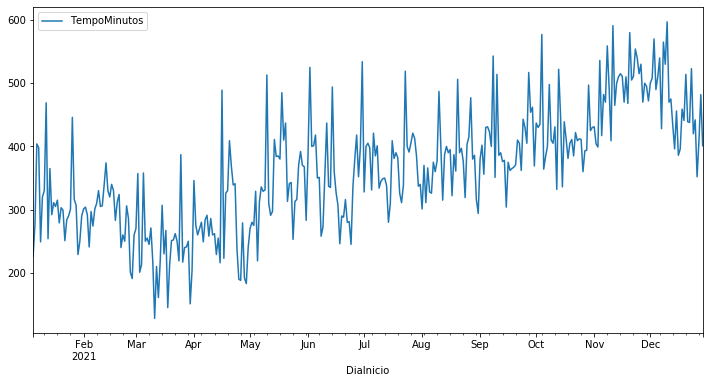

In [7]:
df.plot(figsize=(12,6))

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

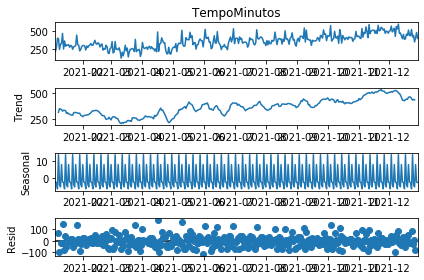

In [9]:
results = seasonal_decompose(df[coluna])
results.plot();

In [10]:
tamDF = len(df)
tamDF

359

In [11]:
# 359-12 = 347
n_previsoes=120
tamTreino = tamDF - n_previsoes
train = df.iloc[:tamTreino]
test = df.iloc[tamTreino:]

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [13]:
df.head(),df.tail()

(            TempoMinutos
 DiaInicio               
 2021-01-05           226
 2021-01-06           276
 2021-01-07           404
 2021-01-08           398
 2021-01-09           249,
             TempoMinutos
 DiaInicio               
 2021-12-25           442
 2021-12-26           352
 2021-12-27           408
 2021-12-28           482
 2021-12-29           401)

In [14]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [15]:
scaled_train[:5]

array([[0.24137931],
       [0.36453202],
       [0.67980296],
       [0.66502463],
       [0.29802956]])

In [16]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
# n_input - qtdade de períodos a serem agrupados(previstos)
n_features = 1
n_input = 14
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [18]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.24137931 0.36453202 0.67980296 0.66502463 0.29802956 0.4729064
 0.49753695 0.83990148 0.31034483 0.58374384 0.40394089 0.45073892
 0.43596059 0.46059113]
Predict this y: 
 [[0.37192118]]


In [19]:
X.shape

(1, 14, 1)

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [22]:
# GRU - REDE RECORRENTE
# Redes Neural GRU -  Gated Recurrent Unit
# Muito semelhante a LSTM

model = Sequential()
model.add(InputLayer((n_input, 1))) # n_tam_agrupamento --> TAMANHO DA JANELA 
model.add(GRU(50))
model.add(Dense(40, 'relu'))
model.add(Dense(40, 'relu'))
model.add(Dense(1, 'linear'))
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.00001), metrics=[RootMeanSquaredError()])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                7950      
                                                                 
 dense (Dense)               (None, 40)                2040      
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 1)                 41        
                                                                 
Total params: 11,671
Trainable params: 11,671
Non-trainable params: 0
_________________________________________________________________


In [24]:
# fit model - a partir de 3 épocas ja não tem mais ganho
model.fit(generator,epochs=10)

Epoch 1/10
225/225 [==============================] - 3s 5ms/step - loss: 0.3048 - root_mean_squared_error: 0.5520
Epoch 2/10
225/225 [==============================] - 1s 5ms/step - loss: 0.2309 - root_mean_squared_error: 0.4805
Epoch 3/10
225/225 [==============================] - 1s 5ms/step - loss: 0.1713 - root_mean_squared_error: 0.4139
Epoch 4/10
225/225 [==============================] - 1s 5ms/step - loss: 0.1255 - root_mean_squared_error: 0.3542
Epoch 5/10
225/225 [==============================] - 1s 5ms/step - loss: 0.0895 - root_mean_squared_error: 0.2991
Epoch 6/10
225/225 [==============================] - 1s 5ms/step - loss: 0.0622 - root_mean_squared_error: 0.2495
Epoch 7/10
225/225 [==============================] - 1s 4ms/step - loss: 0.0423 - root_mean_squared_error: 0.2057
Epoch 8/10
225/225 [==============================] - 1s 5ms/step - loss: 0.0302 - root_mean_squared_error: 0.1738
Epoch 9/10
225/225 [==============================] - 1s 4ms/step - loss: 0.0247

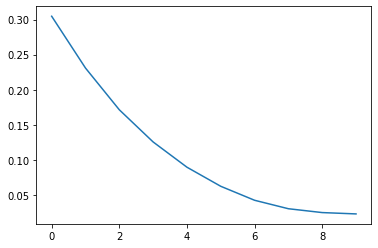

In [25]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [26]:
last_train_batch = scaled_train[-n_input:]

In [27]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [28]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 295ms/step


array([[0.5110657]], dtype=float32)

In [29]:
scaled_test[0]

array([0.62068966])

In [30]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 14ms/step


In [31]:
test_predictions

[array([0.5110657], dtype=float32),
 array([0.50372505], dtype=float32),
 array([0.49761307], dtype=float32),
 array([0.49179572], dtype=float32),
 array([0.48706758], dtype=float32),
 array([0.48284268], dtype=float32),
 array([0.47915992], dtype=float32),
 array([0.47608274], dtype=float32),
 array([0.47305924], dtype=float32),
 array([0.47034496], dtype=float32),
 array([0.46774563], dtype=float32),
 array([0.4657818], dtype=float32),
 array([0.46402645], dtype=float32),
 array([0.46271378], dtype=float32),
 array([0.46162704], dtype=float32),
 array([0.4605264], dtype=float32),
 array([0.45956463], dtype=float32),
 array([0.4587232], dtype=float32),
 array([0.4579876], dtype=float32),
 array([0.45734408], dtype=float32),
 array([0.45678118], dtype=float32),
 array([0.45628887], dtype=float32),
 array([0.45585823], dtype=float32),
 array([0.45548192], dtype=float32),
 array([0.45515317], dtype=float32),
 array([0.45486623], dtype=float32),
 array([0.4546156], dtype=float32),
 array(

In [32]:
test.head()

,TempoMinutos
DiaInicio,
2021-09-01,380
2021-09-02,402
2021-09-03,356
2021-09-04,430
2021-09-05,431


In [33]:
true_predictions = scaler.inverse_transform(test_predictions)

In [34]:
test['Predictions'] = true_predictions

C:\Users\Michael\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
test.head(20)

,TempoMinutos,Predictions
DiaInicio,,
2021-09-01,380,335.492683
2021-09-02,402,332.512371
2021-09-03,356,330.030907
2021-09-04,430,327.669062
2021-09-05,431,325.749438
2021-09-06,423,324.034130
2021-09-07,400,322.538928
2021-09-08,543,321.289593
2021-09-09,351,320.062050


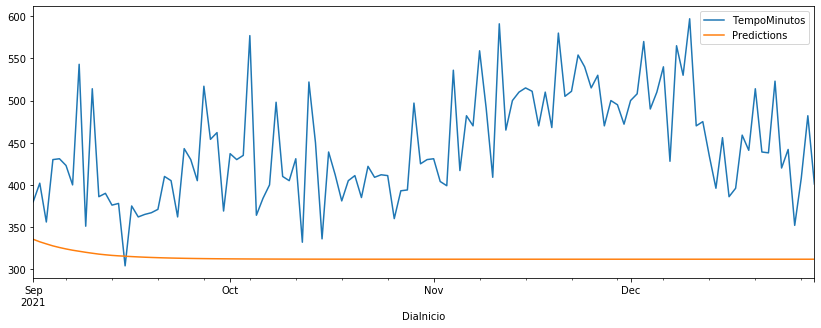

In [36]:
test.plot(figsize=(14,5))

In [37]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test[coluna],test['Predictions']))
print(rmse)

147.67097176447157


In [38]:
test['Diferenca'] = abs(test[coluna]- test['Predictions']) # módulo da diferença
test.head(20)

C:\Users\Michael\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,TempoMinutos,Predictions,Diferenca
DiaInicio,,,
2021-09-01,380,335.492683,44.507317
2021-09-02,402,332.512371,69.487629
2021-09-03,356,330.030907,25.969093
2021-09-04,430,327.669062,102.330938
2021-09-05,431,325.749438,105.250562
2021-09-06,423,324.034130,98.965870
2021-09-07,400,322.538928,77.461072
2021-09-08,543,321.289593,221.710407
2021-09-09,351,320.062050,30.937950


In [ ]:
'''
Resumo:  GRU

a) Tempo de duração da Rotina 04 - Dados NORMALIZADOS

processo = 'Rotina_04' 
coluna = 'TempoMinutos'

3/4    (75% / 25%)	ARIMA(2,1,0)(0,1,1)[12] 	RMSE: 62,27

-----------------------------------------------------------------------------

n_previsoes=15
n_input = 7
model.add(Conv1D(80, kernel_size=2))
model.add(Dense(60, 'relu'))
model.add(Dense(60, 'relu'))
RMSE:   57.95804613623178

n_previsoes=30
n_input = 7
model.add(Conv1D(80, kernel_size=2))
model.add(Dense(60, 'relu'))
model.add(Dense(60, 'relu'))
RMSE:   90.97874891819417

n_previsoes=60
n_input = 7
model.add(Conv1D(80, kernel_size=2))
model.add(Dense(60, 'relu'))
model.add(Dense(60, 'relu'))
RMSE:   136.1622753211613

n_previsoes=120
n_input = 7
model.add(Conv1D(80, kernel_size=2))
model.add(Dense(60, 'relu'))
model.add(Dense(60, 'relu'))
RMSE:   136.62609714514605

-----------------------------------------------------------------------------

n_previsoes=15
n_input = 14
model.add(Conv1D(80, kernel_size=2))
model.add(Dense(60, 'relu'))
model.add(Dense(60, 'relu'))
RMSE:  48.63340461895614

n_previsoes=30
n_input = 14
model.add(Conv1D(80, kernel_size=2))
model.add(Dense(60, 'relu'))
model.add(Dense(60, 'relu'))
RMSE:  81.02706749447549

n_previsoes=60
n_input = 14
model.add(Conv1D(80, kernel_size=2))
model.add(Dense(60, 'relu'))
model.add(Dense(60, 'relu'))
RMSE:  139.88262296948292

n_previsoes=120
n_input = 14
model.add(Conv1D(80, kernel_size=2))
model.add(Dense(60, 'relu'))
model.add(Dense(60, 'relu'))
RMSE:  138.1778941858385

-----------------------------------------------------------------------------

n_previsoes=15
n_input = 14
model.add(Conv1D(60, kernel_size=2))
model.add(Dense(50, 'relu'))
model.add(Dense(50, 'relu'))
RMSE:  52.210669366012

n_previsoes=30
n_input = 14
model.add(Conv1D(60, kernel_size=2))
model.add(Dense(50, 'relu'))
model.add(Dense(50, 'relu'))
RMSE:   74.5219370395821

n_previsoes=60
n_input = 14
model.add(Conv1D(60, kernel_size=2))
model.add(Dense(50, 'relu'))
model.add(Dense(50, 'relu'))
RMSE:   136.63737342803327

n_previsoes=120
n_input = 14
model.add(Conv1D(60, kernel_size=2))
model.add(Dense(50, 'relu'))
model.add(Dense(50, 'relu'))
RMSE:   133.41267336584824

-----------------------------------------------------------------------------


n_previsoes=15
n_input = 14
model.add(Conv1D(50, kernel_size=2))
model.add(Dense(40, 'relu'))
model.add(Dense(40, 'relu'))
RMSE:   59.20766409688115

n_previsoes=30
n_input = 14
model.add(Conv1D(50, kernel_size=2))
model.add(Dense(40, 'relu'))
model.add(Dense(40, 'relu'))
RMSE:   91.78125631674007

n_previsoes=60
n_input = 14
model.add(Conv1D(50, kernel_size=2))
model.add(Dense(40, 'relu'))
model.add(Dense(40, 'relu'))
RMSE:    134.16715519313965

n_previsoes=120
n_input = 14
model.add(Conv1D(50, kernel_size=2))
model.add(Dense(40, 'relu'))
model.add(Dense(40, 'relu'))
RMSE:   147.67097176447157

-----------------------------------------------------------------------------

'''